## Analysis on Dual Thresholds

### Author: Deb Debnath

### Motivation

As part of a discussion with Dr. Sninsky, it could be viable to set two thresholds instead of one for determining prognosis based on the classifier predictions.
The new thresholds are
1. 85% probability of Alzheimer's, i.e. probability score = 0.85
2. 85% probability of being NCI (non-cognitively impaired), i.e score = 0.15

Interpretation of this classification scheme would be
1. **High probability of AD category (Probably AD)** - Seek timely professional medical care for therapy including more aggressive hypertension, diabetes type 2 and obesity therapies as well as amyloid monoclonal antibodies
2. **Intermediate category (Intermediate)** - Self-guided comorbidity risk care (e.g. hypertension, T2 diabetes and obesity), exercise, hearing aids, cognitive engagement with testing in 6 months
3. **High probability of NCI category (Probably NCI)** - Testing in 6 months

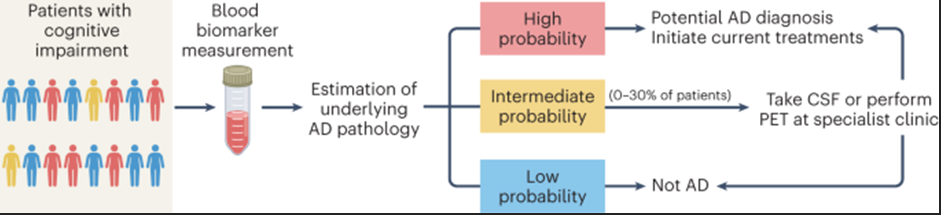

Reference table from _Wimo et al (2014)_
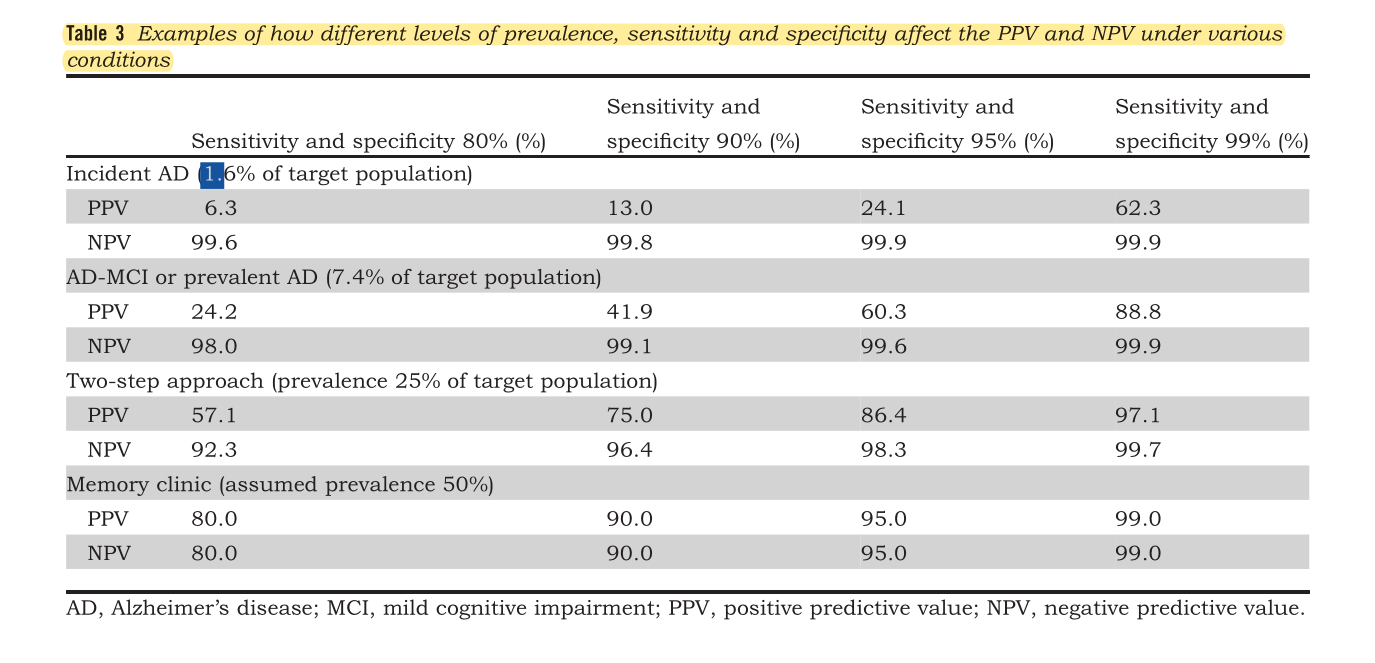

#### Data loading

In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent.resolve()))

In [2]:
from IPython.display import Markdown, display
from dataclasses import dataclass, field
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import confusion_matrix
from src.threshold import plot_uncertainty_at_threshold, plot_v_plot
from src.classifier import z_score, linear_classifier_score, antilogit_classifier_score, sample_single_patient

In [3]:
raw_data = pd.read_excel(
    "../../raw_data/ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet_name=1
)
pathos = pd.read_excel(
    "../../raw_data/ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet_name=0
)

In [4]:
pathos = pathos.set_index("Isolate ID")
raw_data = raw_data.set_index("gene_id")

#### Setting parameters

In [5]:
mean_TPM = 0

In [6]:
num_patients = 243
num_runs = 1000
uncertainties = [10, 25, 50]

In [7]:
thres_1, thres_2 = 0.15, 0.85

In [8]:
seed = 42

In [9]:
np.random.seed(seed)

#### Data preprocessing

In [10]:
patients_df = raw_data[~raw_data.loc[:, "Coeff"].isnull()]
coefficients = np.nan_to_num(np.array(patients_df.loc[:, "Coeff"]))
patients_df = patients_df.filter(regex=r"^\d+")
genes = patients_df.index.values

In [11]:
grouped_cols = patients_df.columns.str.split("-").str[0]
grouped = patients_df.groupby(grouped_cols, axis=1)
patients_df = grouped.apply(lambda x: x.mean(axis=1)).reset_index(drop=True)
patients_df.index = genes

/tmp/ipykernel_223695/2035580270.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped = patients_df.groupby(grouped_cols, axis=1)


#### Conversion to log10(1+TPM), then Z-scores and dropping genes below TPM threshold

In [12]:
log_transformed_df = np.log10(patients_df + 1)

In [13]:
means = patients_df.mean(axis=1)
stds = patients_df.std(axis=1)

In [14]:
logTPM_z_scores_df = log_transformed_df.apply(lambda x: z_score(x, log_transformed_df.mean(axis=1), log_transformed_df.std(axis=1)))
z_scores_df = patients_df.apply(lambda x: z_score(x, means, stds))

In [15]:
logTPM_z_scores_df = logTPM_z_scores_df[means >= mean_TPM]
z_scores_df = z_scores_df[means >= mean_TPM]
coefficients = coefficients[means >= mean_TPM]

#### Container classes for simulation results

In [16]:
@dataclass
class SingleThresholdResults:
    gt_list: list[np.ndarray] = field(default_factory=list)
    preds_list: list[np.ndarray] = field(default_factory=list)
    ad_diff_cls: int = 0
    nci_diff_cls: int = 0    
    
@dataclass
class DualThresholdResults:
    gt_list: list[np.ndarray] = field(default_factory=list)
    preds_list: list[np.ndarray] = field(default_factory=list)
    ad_diff_cls: int = 0
    int_diff_cls: int = 0
    nci_diff_cls: int = 0

## Single and Dual threshold experiments

In [17]:
def simulate_sampling_experiment(
            z_scores_df: pd.DataFrame, 
            *,
            thres_1: float, 
            thres_2: float, 
            uncertainty: float,
            num_runs: int,
            coefficients: np.ndarray | pd.Series, 
            num_patients: int = 243
    ) -> tuple[SingleThresholdResults, DualThresholdResults, np.ndarray, np.ndarray]:
    """
    Perform simulation experiments for single and dual thresholds, return the predicted and ground truth classes 
    and number of differentially classified individuals for each class, along with all predicted linear scores and probabilities.
    """
    pred_linear_scores = []
    pred_probs = []

    # Single and dual threshold result variables
    single_thres_res = SingleThresholdResults()
    dual_thres_res = DualThresholdResults()

    for i in range(num_patients):
        col = z_scores_df.iloc[:, i]

        # Generate MC samples from distribution
        lin_scores, probs = sample_single_patient(col, coefficients, num_runs, uncertainty)
        y_0 = antilogit_classifier_score(linear_classifier_score(coefficients, col))

        # Keep track of linear scores and simulated probabilities
        pred_linear_scores.append(lin_scores)
        pred_probs.append(probs)

        # Single threshold calculations
        gt_label = 0 if y_0 < thres_1 else 1
        
        preds = np.zeros(num_runs, dtype=np.int64)
        preds[(thres_1 <= probs)] = 1 
    
        if gt_label == 0 and 1 in preds:
            single_thres_res.ad_diff_cls += 1
        if gt_label == 1 and 0 in preds:
            single_thres_res.nci_diff_cls += 1
            
        gt_arr = np.ones(num_runs, dtype=np.int64) * gt_label
        single_thres_res.gt_list.append(gt_arr)
        single_thres_res.preds_list.append(preds)

        # Dual threshold calculations
        if y_0 < thres_1:
            gt_label = 0
        elif thres_1 <= y_0 < thres_2:
            gt_label = 1
        else:
            gt_label = 2

        preds = np.zeros(num_runs, dtype=np.int64)
        preds[(thres_1 <= probs) & (probs < thres_2)] = 1 
        preds[probs >= thres_2] = 2
    
        if gt_label == 0 and (1 in preds or 2 in preds):
            dual_thres_res.nci_diff_cls += 1
        elif gt_label == 1 and (0 in preds or 2 in preds):
            dual_thres_res.int_diff_cls += 1
        elif gt_label == 2 and (0 in preds or 1 in preds):
            dual_thres_res.ad_diff_cls += 1
        
        gt_arr = np.ones(num_runs, dtype=np.int64) * gt_label
        dual_thres_res.gt_list.append(gt_arr)
        dual_thres_res.preds_list.append(preds)
            
    lin_scores_all = np.hstack(pred_linear_scores)
    pred_probs_all = np.hstack(pred_probs)
    return single_thres_res, dual_thres_res, lin_scores_all, pred_probs_all

In [18]:
single_thres_expt_results = pd.DataFrame(index=uncertainties, 
                                  columns=["ad_diff_cls", "nci_diff_cls",
                                           "logTPM_ad_diff_cls", "logTPM_nci_diff_cls"])

In [19]:
dual_thres_expt_results = pd.DataFrame(index=uncertainties, 
                                  columns=["ad_diff_cls", "int_diff_cls", "nci_diff_cls", 
                                           "logTPM_ad_diff_cls", "logTPM_int_diff_cls", "logTPM_nci_diff_cls",
                                    ])

In [20]:
score_stats = pd.DataFrame(index=uncertainties,
                           columns=[
                               "mean_lin", "std_lin", "mean_probs", "std_probs",
                               "logTPM_mean_lin", "logTPM_std_lin", "logTPM_mean_probs", "logTPM_std_probs"
                           ])

In [21]:
lin_score_arrs, pred_prob_arrs = {uncert: None for uncert in uncertainties}, {uncert: None for uncert in uncertainties}
logTPM_lin_score_arrs, logTPM_pred_prob_arrs = {uncert: None for uncert in uncertainties}, {uncert: None for uncert in uncertainties}

In [22]:
single_thres_gt_arrs, single_thres_pred_arrs = {uncert: None for uncert in uncertainties}, {uncert: None for uncert in uncertainties}
single_thres_logTPM_gt_arrs, single_thres_logTPM_pred_arrs = {uncert: None for uncert in uncertainties}, {uncert: None for uncert in uncertainties}

In [23]:
dual_thres_gt_arrs, dual_thres_pred_arrs = {uncert: None for uncert in uncertainties}, {uncert: None for uncert in uncertainties}
dual_thres_logTPM_gt_arrs, dual_thres_logTPM_pred_arrs = {uncert: None for uncert in uncertainties}, {uncert: None for uncert in uncertainties}

### Without log transform

#### Simulations

In [24]:
for uncertainty in uncertainties:
    single_thres_res, dual_thres_res, lin_scores, pred_probs = simulate_sampling_experiment(
                    z_scores_df, thres_1=thres_1, thres_2=thres_2, coefficients=coefficients, uncertainty=uncertainty, num_runs=num_runs, num_patients=num_patients)
    single_thres_gt_arrs[uncertainty], single_thres_pred_arrs[uncertainty] = np.hstack(single_thres_res.gt_list), np.hstack(single_thres_res.preds_list)
    dual_thres_gt_arrs[uncertainty], dual_thres_pred_arrs[uncertainty] = np.hstack(dual_thres_res.gt_list), np.hstack(dual_thres_res.preds_list)
    lin_score_arrs[uncertainty], pred_prob_arrs[uncertainty] = lin_scores, pred_probs
    single_thres_expt_results.loc[uncertainty, "ad_diff_cls"] = single_thres_res.ad_diff_cls
    single_thres_expt_results.loc[uncertainty, "nci_diff_cls"] = single_thres_res.nci_diff_cls
    dual_thres_expt_results.loc[uncertainty, "ad_diff_cls"] = dual_thres_res.ad_diff_cls
    dual_thres_expt_results.loc[uncertainty, "int_diff_cls"] = dual_thres_res.int_diff_cls
    dual_thres_expt_results.loc[uncertainty, "nci_diff_cls"] = dual_thres_res.nci_diff_cls
    score_stats.loc[uncertainty, "mean_lin"] = np.mean(lin_scores)
    score_stats.loc[uncertainty, "std_lin"] = np.std(lin_scores)
    score_stats.loc[uncertainty, "mean_probs"] = np.mean(pred_probs)
    score_stats.loc[uncertainty, "std_probs"] = np.std(pred_probs)

### With log transform

#### Simulations

In [25]:
for uncertainty in uncertainties:
    single_thres_res, dual_thres_res, lin_scores, pred_probs = simulate_sampling_experiment(
                logTPM_z_scores_df, thres_1=thres_1, thres_2=thres_2, coefficients=coefficients, uncertainty=uncertainty, num_runs=num_runs, num_patients=num_patients)
    single_thres_logTPM_gt_arrs[uncertainty], single_thres_logTPM_pred_arrs[uncertainty] = np.hstack(single_thres_res.gt_list), np.hstack(single_thres_res.preds_list)
    dual_thres_logTPM_gt_arrs[uncertainty], dual_thres_logTPM_pred_arrs[uncertainty] = np.hstack(dual_thres_res.gt_list), np.hstack(dual_thres_res.preds_list)
    logTPM_lin_score_arrs[uncertainty], logTPM_pred_prob_arrs[uncertainty] = lin_scores, pred_probs
    single_thres_expt_results.loc[uncertainty, "logTPM_ad_diff_cls"] = single_thres_res.ad_diff_cls
    single_thres_expt_results.loc[uncertainty, "logTPM_nci_diff_cls"] = single_thres_res.nci_diff_cls
    dual_thres_expt_results.loc[uncertainty, "logTPM_ad_diff_cls"] = dual_thres_res.ad_diff_cls
    dual_thres_expt_results.loc[uncertainty, "logTPM_int_diff_cls"] = dual_thres_res.int_diff_cls
    dual_thres_expt_results.loc[uncertainty, "logTPM_nci_diff_cls"] = dual_thres_res.nci_diff_cls
    score_stats.loc[uncertainty, "logTPM_mean_lin"] = np.mean(lin_scores)
    score_stats.loc[uncertainty, "logTPM_std_lin"] = np.std(lin_scores)
    score_stats.loc[uncertainty, "logTPM_mean_probs"] = np.mean(pred_probs)
    score_stats.loc[uncertainty, "logTPM_std_probs"] = np.std(pred_probs)

## Analysis of results

In [26]:
def plot_confusion_matrix(cnf_mat: np.ndarray, categories: list[str]) -> None:
    """
    Plot confusion matrix for simulation output.
    """
    if cnf_mat.shape[0] != len(categories):
        raise ValueError("Dimension of confusion matrix does not match the number of categories.")
    cnf_mat_df = pd.DataFrame(cnf_mat.astype(np.int64), index=categories, columns=categories)
    plt.figure(figsize=(10, 10))
    plt.title("Confusion matrix", fontsize=28)
    sns.heatmap(cnf_mat_df, annot=True, cbar=False, fmt="g", annot_kws={"size": 18})
    plt.tick_params(labelsize=18)
    plt.xlabel("Predicted", fontsize=24)
    plt.ylabel("True", fontsize=24)
    plt.show()

In [27]:
def calculate_sens_spec_dual_threshold(cnf_mat: np.ndarray) -> str:
    """
    Calculates and displays sensitivity and specificity for Alzheimer's disease (AD)
    and NCI categories from a confusion matrix for results from dual threshold simulations.
    """
    if cnf_mat.shape[0] != 3:
        raise ValueError("Confusion matrix should be 3x3.")
    # AD
    ad_tp = cnf_mat[2, 2]
    ad_tn = np.sum(cnf_mat[:2, :2])
    ad_fp = np.sum(cnf_mat[:2, 2])
    ad_fn = np.sum(cnf_mat[2, :2])
    sensitivity_AD = ad_tp / (ad_tp + ad_fn)
    specificity_AD = ad_tn / (ad_tn + ad_fp)
    ppv_AD = ad_tp / (ad_tp + ad_fp)
    npv_AD = ad_tn / (ad_tn + ad_fn)

    # NCI
    nci_tp = cnf_mat[0, 0]
    nci_tn = np.sum(cnf_mat[1:, 1:])
    nci_fp = np.sum(cnf_mat[1:, 0])
    nci_fn = np.sum(cnf_mat[0, 1:])
    sensitivity_NCI = nci_tp / (nci_tp + nci_fn)
    specificity_NCI = nci_tn / (nci_tn + nci_fp)
    ppv_NCI = nci_tp / (nci_tp + nci_fp)
    npv_NCI = nci_tn / (nci_tn + nci_fn)

    string = f"""
    | **Metric**    | **AD (%)** | **NCI (%)** |
    |---------------|------------|-------------|
    | Sensitivity   | {sensitivity_AD * 100:.2f} | {sensitivity_NCI * 100:.2f}|
    | Specificity   | {specificity_AD * 100:.2f} | {specificity_NCI * 100:.2f} |
    | PPV           | {ppv_AD * 100:.2f} | {ppv_NCI * 100:.2f} |
    | NPV           | {npv_AD * 100:.2f} | {npv_NCI * 100:.2f} |
    """
    return string

In [28]:
def display_differential_classification_results_one_threshold(*, ad_diff_cls: int, nci_diff_cls: int, num_patients: int) -> None:
    """
    Calculate metrics of differential classification and display results (single threshold).
    """
    print(f"{ad_diff_cls / num_patients * 100:.2f} % simulated subjects were differentially classified from the Alzheimer's disease category.")
    print(f"{nci_diff_cls / num_patients * 100:.2f} % simulated subjects were differentially classified from the NCI category.")
    print(f"{(ad_diff_cls + nci_diff_cls) / num_patients * 100:.2f} % simulated subjects were differentially classified between AD and NCI categories.")
    print(f"Total number of differentially classified individuals: {(ad_diff_cls + nci_diff_cls)}")

In [29]:
def display_differential_classification_results_two_thresholds(*, ad_diff_cls: int, int_diff_cls: int, nci_diff_cls: int, num_patients: int) -> None:
    """
    Calculate metrics of differential classification and display results (two thresholds).
    """
    print(f"{ad_diff_cls / num_patients * 100:.2f} % simulated subjects were differentially classified from the Alzheimer's disease category.")
    print(f"{int_diff_cls / num_patients * 100:.2f} % simulated subjects were differentially classified from the intermediate category.")
    print(f"{nci_diff_cls / num_patients * 100:.2f} % simulated subjects were differentially classified from the NCI category.")
    print(f"Fraction of simulated subjects differentially classified: Approximately {(ad_diff_cls + int_diff_cls + nci_diff_cls) / num_patients * 100:.2f}%")
    print(f"Total number of differentially classified individuals: {(ad_diff_cls + int_diff_cls + nci_diff_cls)}")

In [30]:
def visualize_differential_classification_results_two_thresholds(*,
            ad_diff_cls: int, interm_diff_cls: int, nci_diff_cls: int,
            logTPM_ad_diff_cls: int, logTPM_interm_diff_cls: int, logTPM_nci_diff_cls: int,
            uncertainty: int
    ) -> None:
    """
    Visualize the number of differentially classified individuals
    """
    diff_cls = [ad_diff_cls, interm_diff_cls, nci_diff_cls]
    logTPM_diff_cls = [logTPM_ad_diff_cls, logTPM_interm_diff_cls, logTPM_nci_diff_cls]
    width = 0.3
    plt.figure(figsize=(8, 4))
    fig, ax = plt.subplots()
    ax.bar(np.arange(len(diff_cls)), diff_cls, width, label="Without log transform")
    ax.bar(np.arange(len(logTPM_diff_cls))+width, logTPM_diff_cls, width, label="With log transform")
    plt.xlabel("Category")
    plt.ylabel("Number of individuals differentially classified")
    plt.title(f"Effect of log transformation on differential classification (Two thresholds, {uncertainty} % uncertainty)")
    plt.xticks(np.arange(len(diff_cls))+width/2, ["AD", "Intermediate", "NCI"])
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [31]:
def visualize_differential_classification_results_single_threshold(*,
            ad_diff_cls: int, nci_diff_cls: int,
            logTPM_ad_diff_cls: int, logTPM_nci_diff_cls: int,
            uncertainty: int
    ) -> None:
    diff_cls = [ad_diff_cls, nci_diff_cls]
    logTPM_diff_cls = [logTPM_ad_diff_cls, logTPM_nci_diff_cls]
    width = 0.3
    plt.figure(figsize=(8, 6))
    fig, ax = plt.subplots()
    ax.bar(np.arange(len(diff_cls)), diff_cls, width, label="Without log transform")
    ax.bar(np.arange(len(logTPM_diff_cls))+width, logTPM_diff_cls, width, label="With log transform")
    plt.xlabel("Category")
    plt.ylabel("Number of individuals differentially classified")
    plt.title(f"Effect of log transformation on differential classification (Single threshold, {uncertainty} % uncertainty)")
    plt.xticks(np.arange(len(diff_cls))+width/2, ["AD", "NCI"])
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

In [32]:
single_thres_cnf_mats, single_thres_logTPM_cnf_mats = {}, {}
dual_thres_cnf_mats, dual_thres_logTPM_cnf_mats = {}, {}

### Without log transform

#### Confusion matrix

------------------10 % uncertainty-------------------


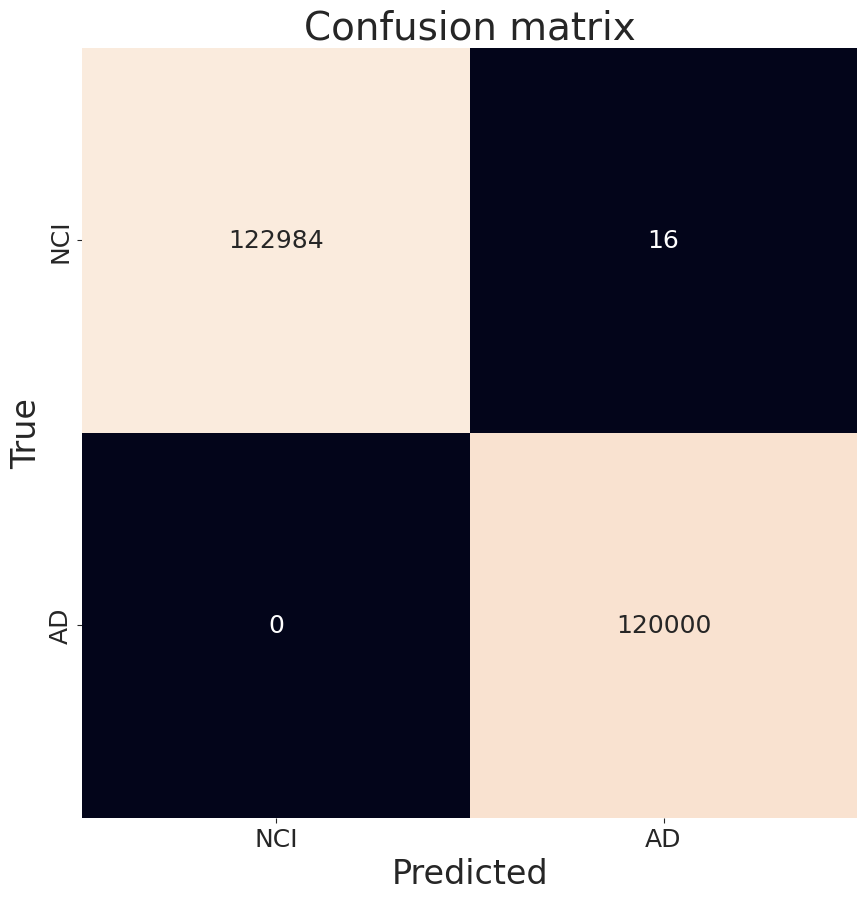

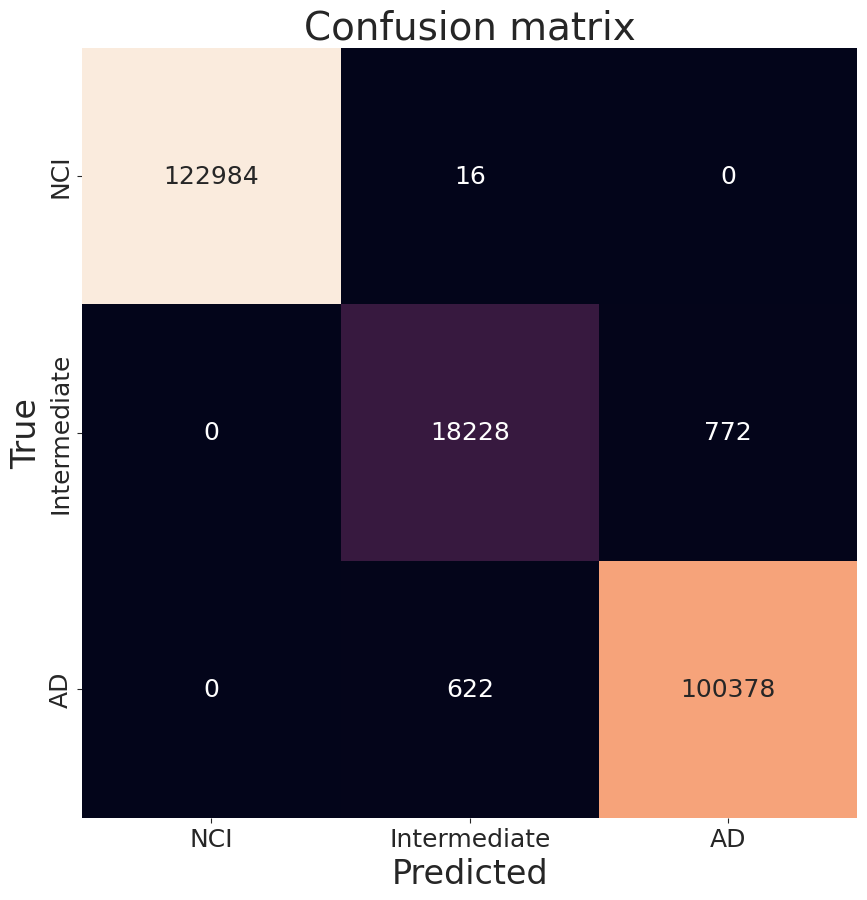

------------------25 % uncertainty-------------------


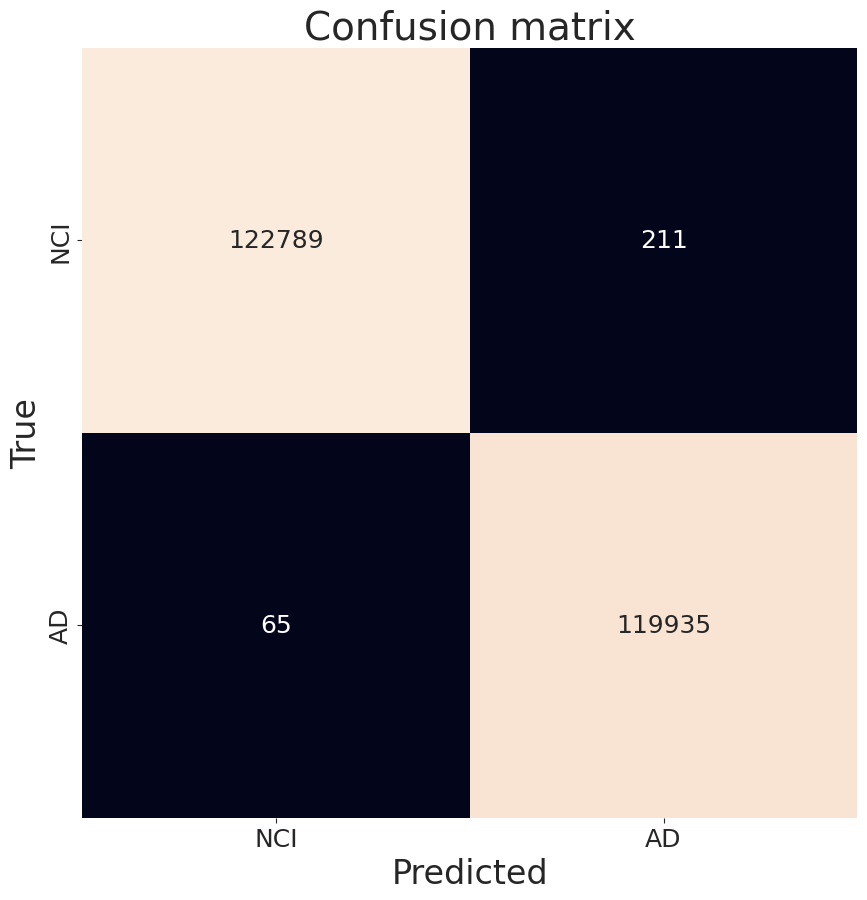

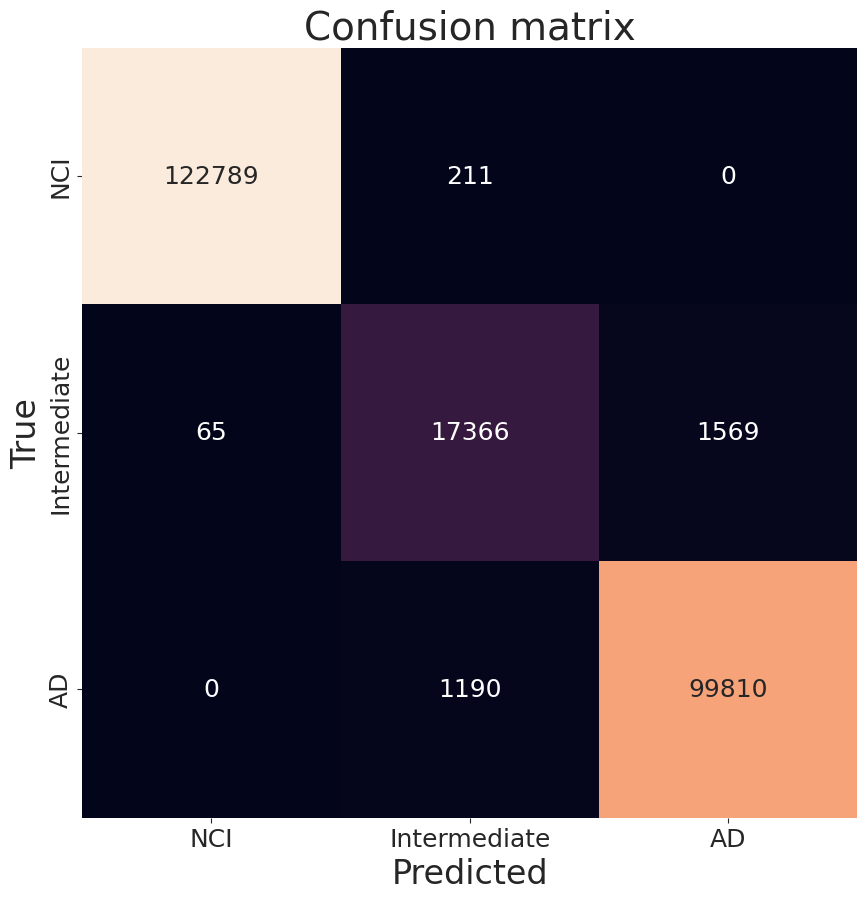

------------------50 % uncertainty-------------------


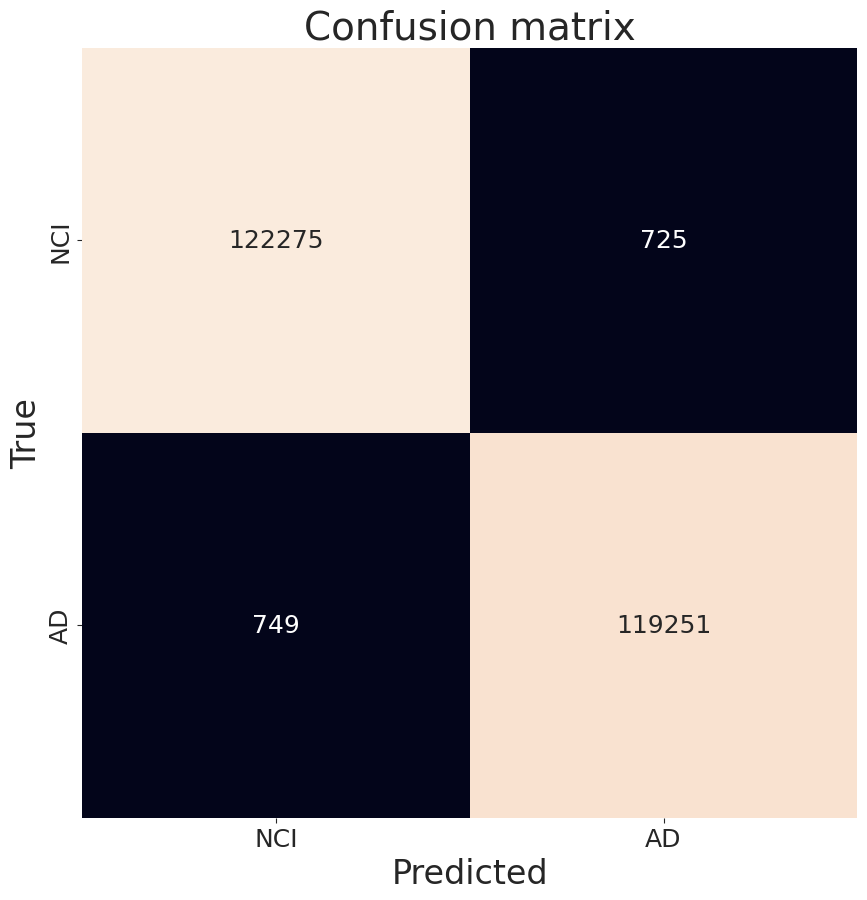

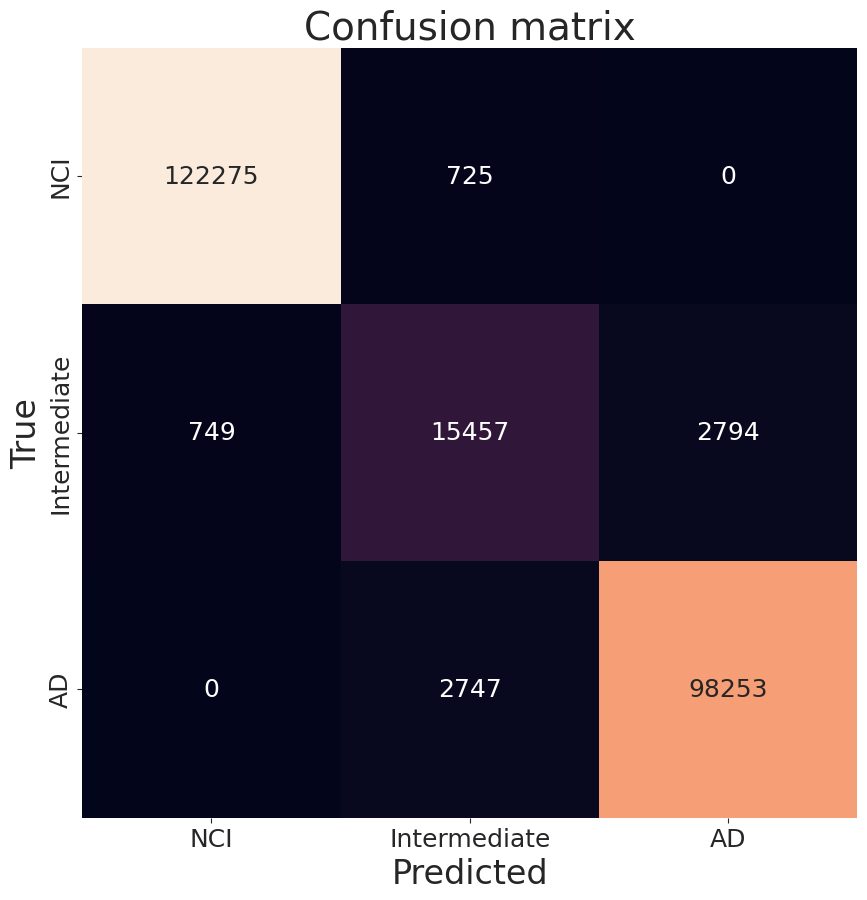

In [33]:
for uncertainty in uncertainties:
    single_thres_cnf_mats[uncertainty] = confusion_matrix(single_thres_gt_arrs[uncertainty], single_thres_pred_arrs[uncertainty])
    dual_thres_cnf_mats[uncertainty] = confusion_matrix(dual_thres_gt_arrs[uncertainty], dual_thres_pred_arrs[uncertainty])
    print(f"------------------{uncertainty} % uncertainty-------------------")
    plot_confusion_matrix(single_thres_cnf_mats[uncertainty], ["NCI", "AD"])
    plot_confusion_matrix(dual_thres_cnf_mats[uncertainty], ["NCI", "Intermediate", "AD"])

#### Sensitivity and Specificity

In [34]:
for uncertainty in uncertainties:
    print(f"------------------{uncertainty} % uncertainty-------------------")
    display(Markdown(calculate_sens_spec_dual_threshold(dual_thres_cnf_mats[uncertainty])))

------------------10 % uncertainty-------------------



    | **Metric**    | **AD (%)** | **NCI (%)** |
    |---------------|------------|-------------|
    | Sensitivity   | 99.38 | 99.99|
    | Specificity   | 99.46 | 100.00 |
    | PPV           | 99.24 | 100.00 |
    | NPV           | 99.56 | 99.99 |
    

------------------25 % uncertainty-------------------



    | **Metric**    | **AD (%)** | **NCI (%)** |
    |---------------|------------|-------------|
    | Sensitivity   | 98.82 | 99.83|
    | Specificity   | 98.90 | 99.95 |
    | PPV           | 98.45 | 99.95 |
    | NPV           | 99.16 | 99.82 |
    

------------------50 % uncertainty-------------------



    | **Metric**    | **AD (%)** | **NCI (%)** |
    |---------------|------------|-------------|
    | Sensitivity   | 97.28 | 99.41|
    | Specificity   | 98.03 | 99.38 |
    | PPV           | 97.23 | 99.39 |
    | NPV           | 98.06 | 99.40 |
    

#### Differential Classification

A **differentially classified subject** is a subject (patient) that has one or more simulated scores that produced a different classification into AD/NCI than the actual score.

In [35]:
for uncertainty in uncertainties:
    print(f"------------------{uncertainty} % uncertainty-------------------")
    print("Single threshold:")
    display_differential_classification_results_one_threshold(
                ad_diff_cls=single_thres_expt_results.loc[uncertainty, "ad_diff_cls"],
                nci_diff_cls=single_thres_expt_results.loc[uncertainty, "nci_diff_cls"], 
                num_patients=num_patients)
    print("Dual threshold:")
    display_differential_classification_results_two_thresholds(
                ad_diff_cls=dual_thres_expt_results.loc[uncertainty, "ad_diff_cls"], 
                int_diff_cls=dual_thres_expt_results.loc[uncertainty, "int_diff_cls"], 
                nci_diff_cls=dual_thres_expt_results.loc[uncertainty, "nci_diff_cls"], 
                num_patients=num_patients)

------------------10 % uncertainty-------------------
Single threshold:
0.41 % simulated subjects were differentially classified from the Alzheimer's disease category.
0.00 % simulated subjects were differentially classified from the NCI category.
0.41 % simulated subjects were differentially classified between AD and NCI categories.
Total number of differentially classified individuals: 1
Dual threshold:
1.23 % simulated subjects were differentially classified from the Alzheimer's disease category.
2.06 % simulated subjects were differentially classified from the intermediate category.
0.41 % simulated subjects were differentially classified from the NCI category.
Fraction of simulated subjects differentially classified: Approximately 3.70%
Total number of differentially classified individuals: 9
------------------25 % uncertainty-------------------
Single threshold:
1.65 % simulated subjects were differentially classified from the Alzheimer's disease category.
2.06 % simulated subjec

### With log transform

#### Confusion matrix

------------------10 % uncertainty-------------------


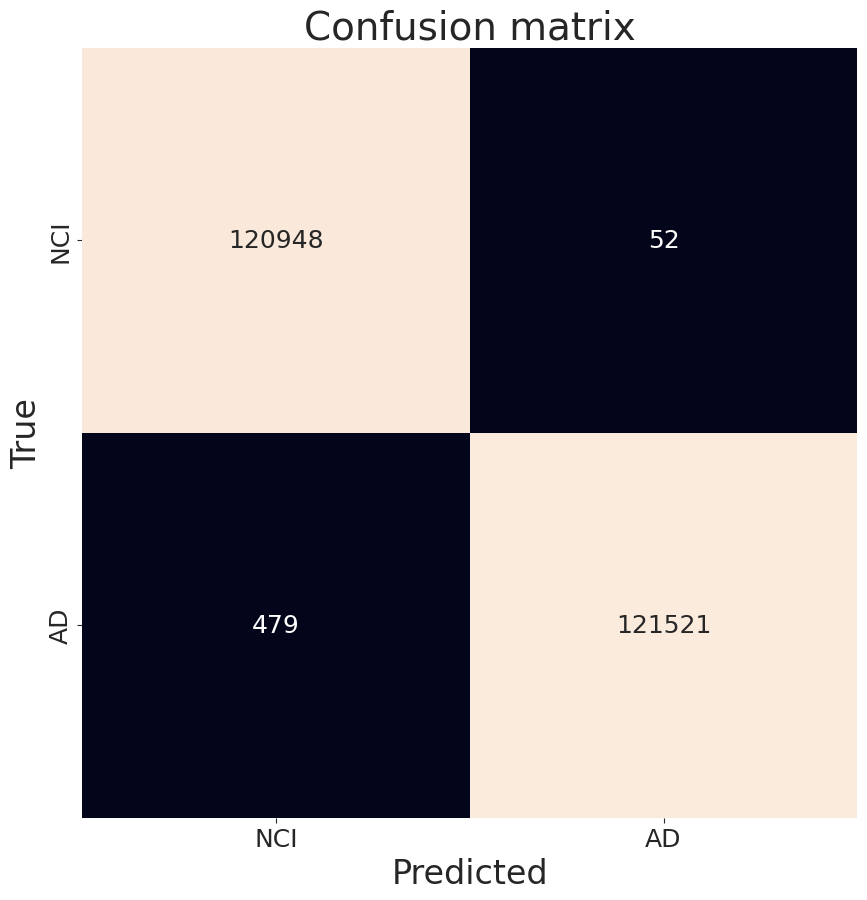

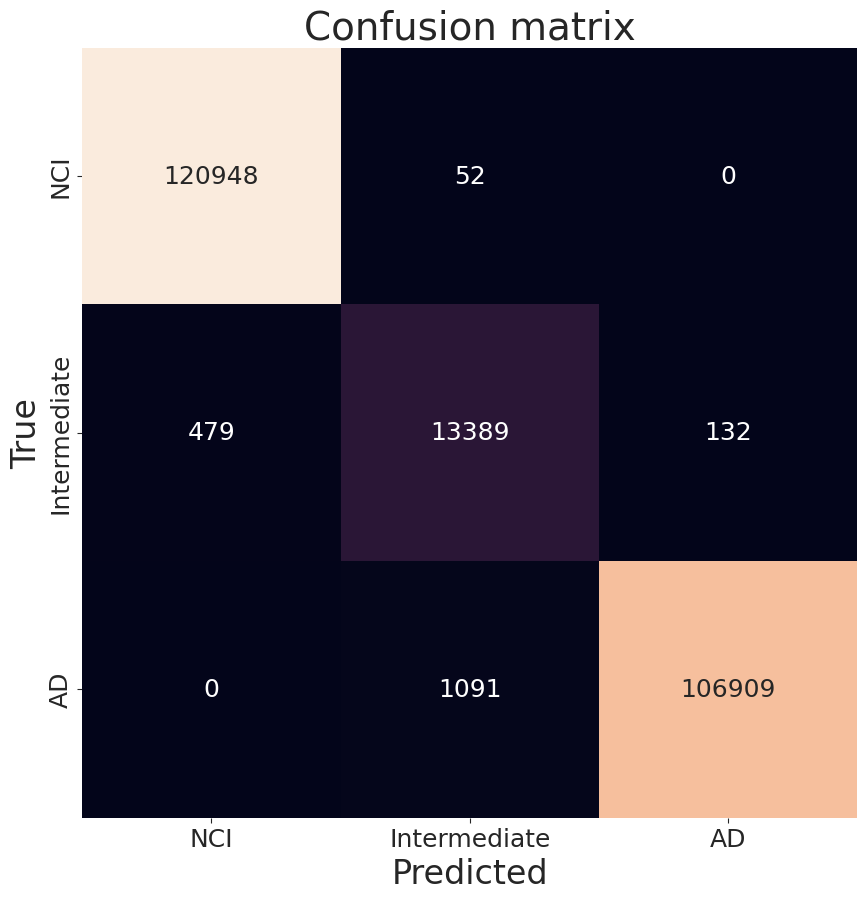

------------------25 % uncertainty-------------------


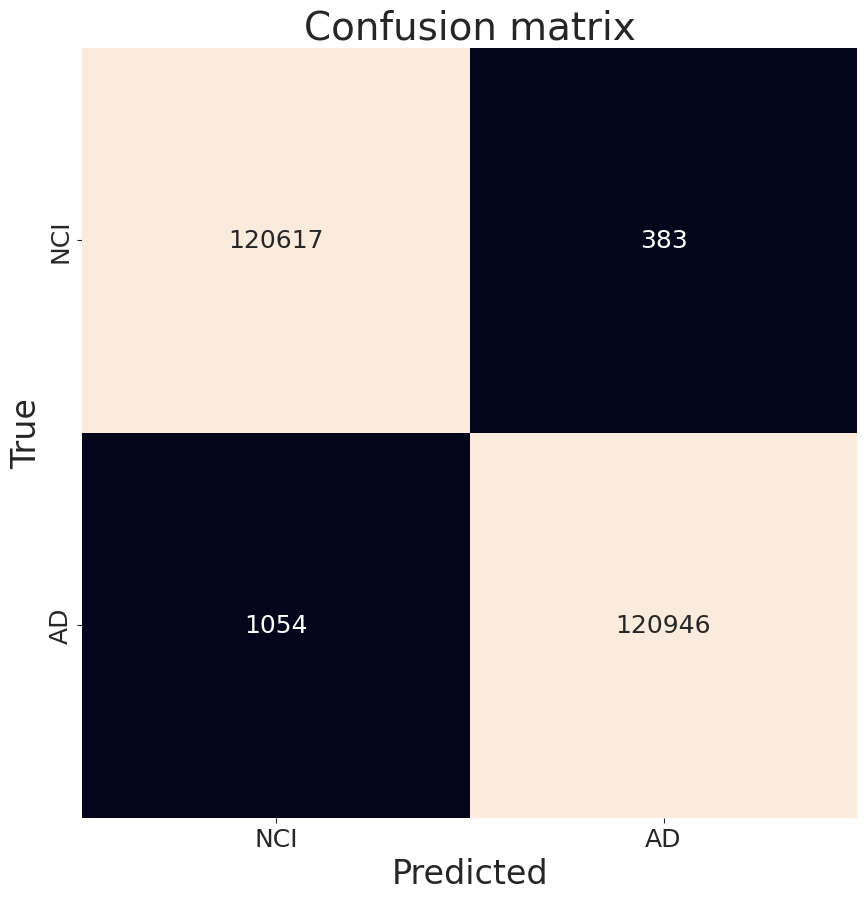

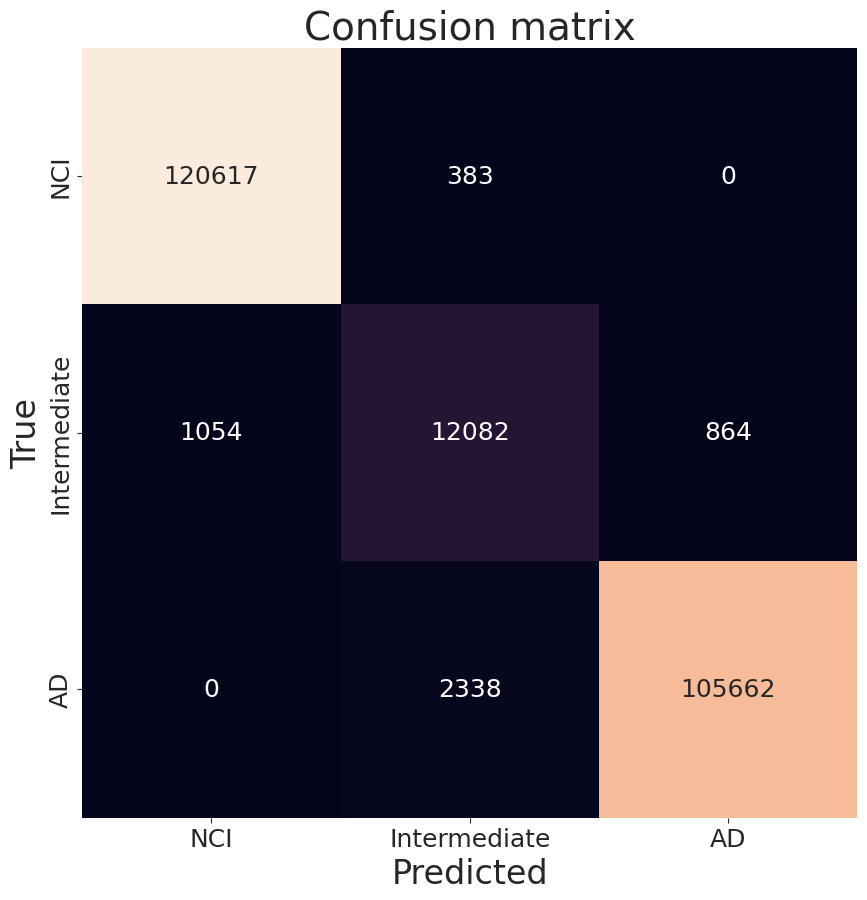

------------------50 % uncertainty-------------------


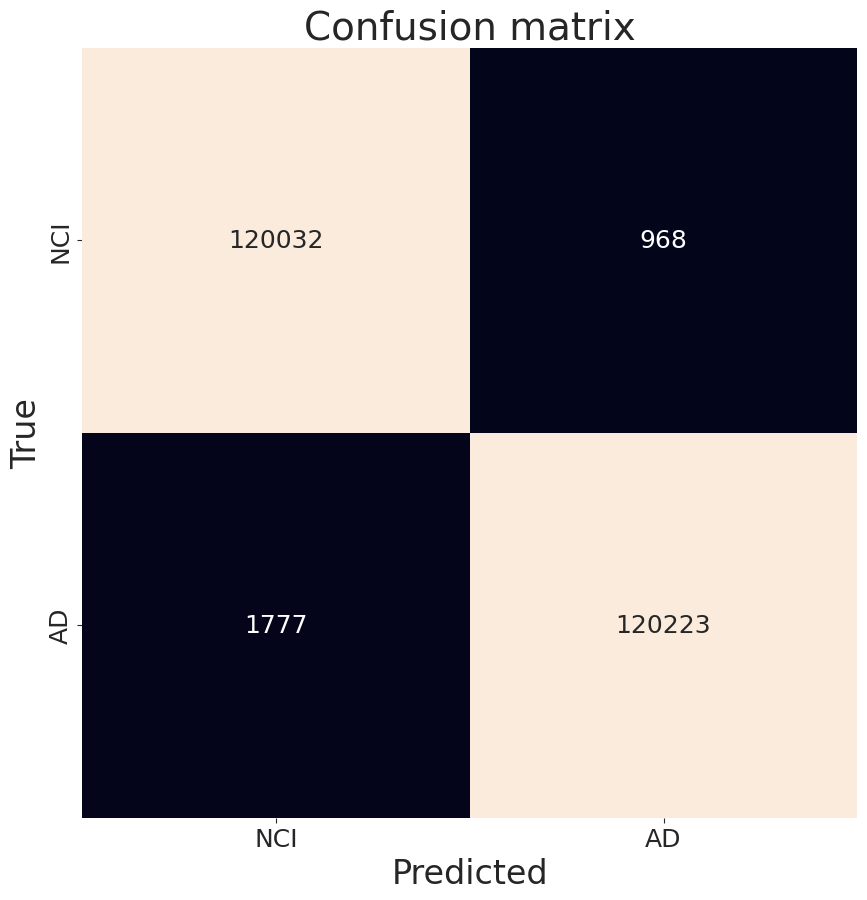

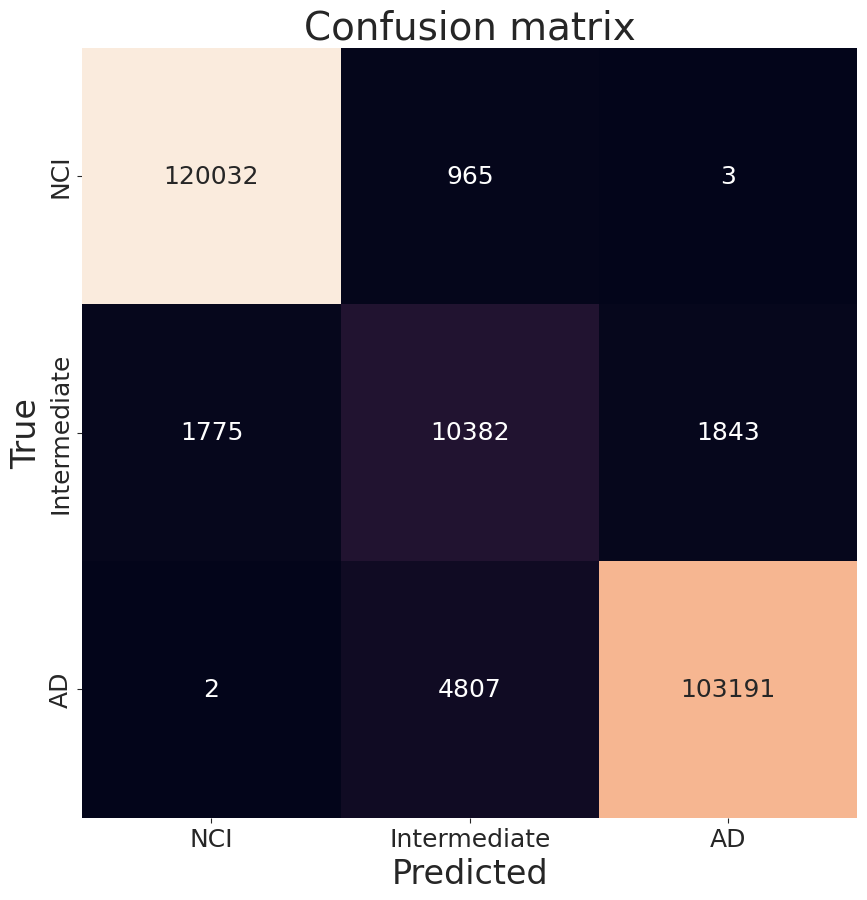

In [36]:
for uncertainty in uncertainties:
    single_thres_logTPM_cnf_mats[uncertainty] = confusion_matrix(single_thres_logTPM_gt_arrs[uncertainty], single_thres_logTPM_pred_arrs[uncertainty])
    dual_thres_logTPM_cnf_mats[uncertainty] = confusion_matrix(dual_thres_logTPM_gt_arrs[uncertainty], dual_thres_logTPM_pred_arrs[uncertainty])
    print(f"------------------{uncertainty} % uncertainty-------------------")
    plot_confusion_matrix(single_thres_logTPM_cnf_mats[uncertainty], ["NCI", "AD"])
    plot_confusion_matrix(dual_thres_logTPM_cnf_mats[uncertainty], ["NCI", "Intermediate", "AD"])

#### Sensitivity and Specificity

In [37]:
for uncertainty in uncertainties:
    print(f"------------------{uncertainty} % uncertainty-------------------")
    display(Markdown(calculate_sens_spec_dual_threshold(dual_thres_logTPM_cnf_mats[uncertainty])))

------------------10 % uncertainty-------------------



    | **Metric**    | **AD (%)** | **NCI (%)** |
    |---------------|------------|-------------|
    | Sensitivity   | 98.99 | 99.96|
    | Specificity   | 99.90 | 99.61 |
    | PPV           | 99.88 | 99.61 |
    | NPV           | 99.20 | 99.96 |
    

------------------25 % uncertainty-------------------



    | **Metric**    | **AD (%)** | **NCI (%)** |
    |---------------|------------|-------------|
    | Sensitivity   | 97.84 | 99.68|
    | Specificity   | 99.36 | 99.14 |
    | PPV           | 99.19 | 99.13 |
    | NPV           | 98.29 | 99.68 |
    

------------------50 % uncertainty-------------------



    | **Metric**    | **AD (%)** | **NCI (%)** |
    |---------------|------------|-------------|
    | Sensitivity   | 95.55 | 99.20|
    | Specificity   | 98.63 | 98.54 |
    | PPV           | 98.24 | 98.54 |
    | NPV           | 96.51 | 99.20 |
    

#### Differential Classification

In [38]:
for uncertainty in uncertainties:
    print(f"------------------{uncertainty} % uncertainty-------------------")
    print("Single threshold:")
    display_differential_classification_results_one_threshold(
                ad_diff_cls=single_thres_expt_results.loc[uncertainty, "logTPM_ad_diff_cls"],
                nci_diff_cls=single_thres_expt_results.loc[uncertainty, "logTPM_nci_diff_cls"], 
                num_patients=num_patients)
    print("Dual threshold:")
    display_differential_classification_results_two_thresholds(
                ad_diff_cls=dual_thres_expt_results.loc[uncertainty, "logTPM_ad_diff_cls"], 
                int_diff_cls=dual_thres_expt_results.loc[uncertainty, "logTPM_int_diff_cls"], 
                nci_diff_cls=dual_thres_expt_results.loc[uncertainty, "logTPM_nci_diff_cls"], 
                num_patients=num_patients)

------------------10 % uncertainty-------------------
Single threshold:
0.41 % simulated subjects were differentially classified from the Alzheimer's disease category.
1.65 % simulated subjects were differentially classified from the NCI category.
2.06 % simulated subjects were differentially classified between AD and NCI categories.
Total number of differentially classified individuals: 5
Dual threshold:
3.29 % simulated subjects were differentially classified from the Alzheimer's disease category.
2.88 % simulated subjects were differentially classified from the intermediate category.
0.41 % simulated subjects were differentially classified from the NCI category.
Fraction of simulated subjects differentially classified: Approximately 6.58%
Total number of differentially classified individuals: 16
------------------25 % uncertainty-------------------
Single threshold:
1.65 % simulated subjects were differentially classified from the Alzheimer's disease category.
2.06 % simulated subje

<Figure size 800x600 with 0 Axes>

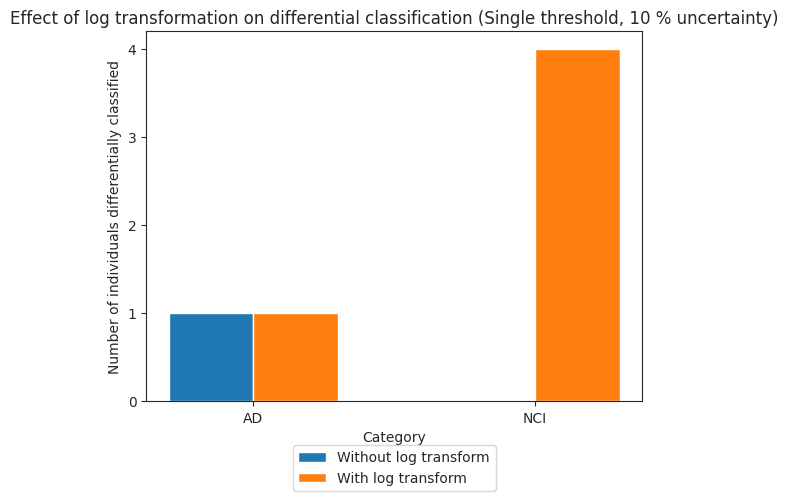

<Figure size 800x400 with 0 Axes>

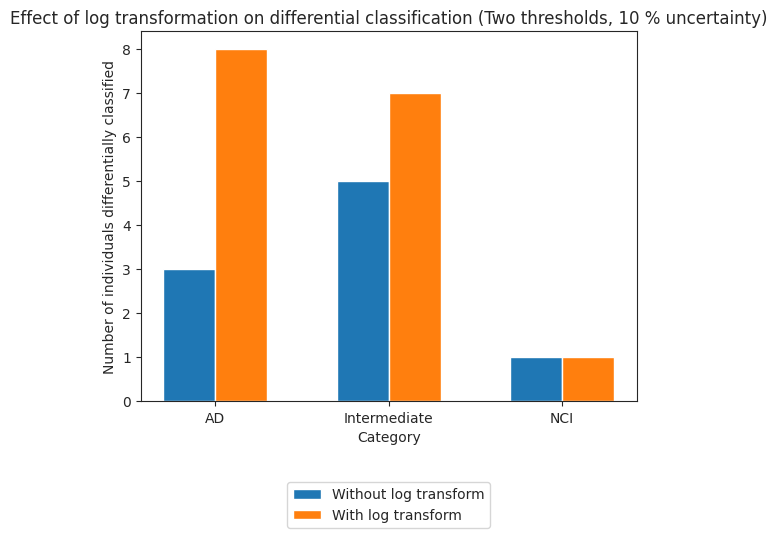

<Figure size 800x600 with 0 Axes>

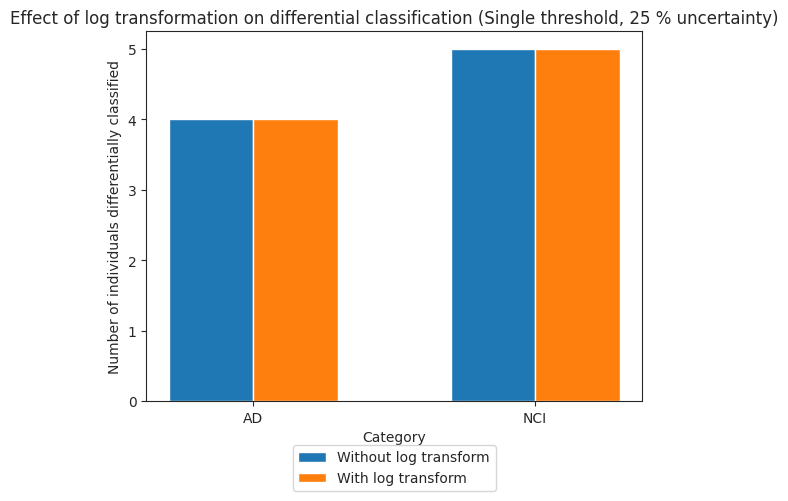

<Figure size 800x400 with 0 Axes>

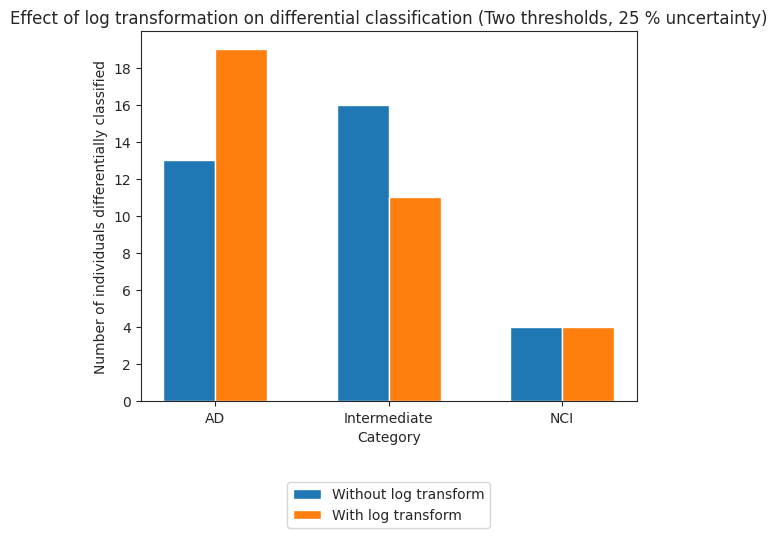

<Figure size 800x600 with 0 Axes>

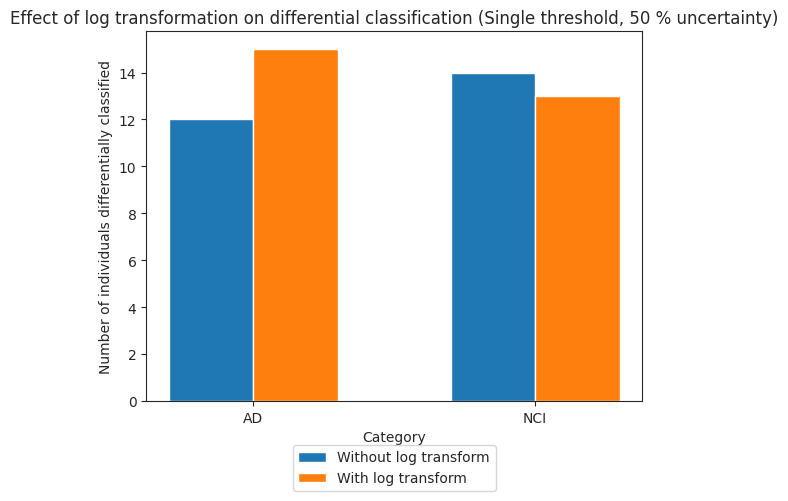

<Figure size 800x400 with 0 Axes>

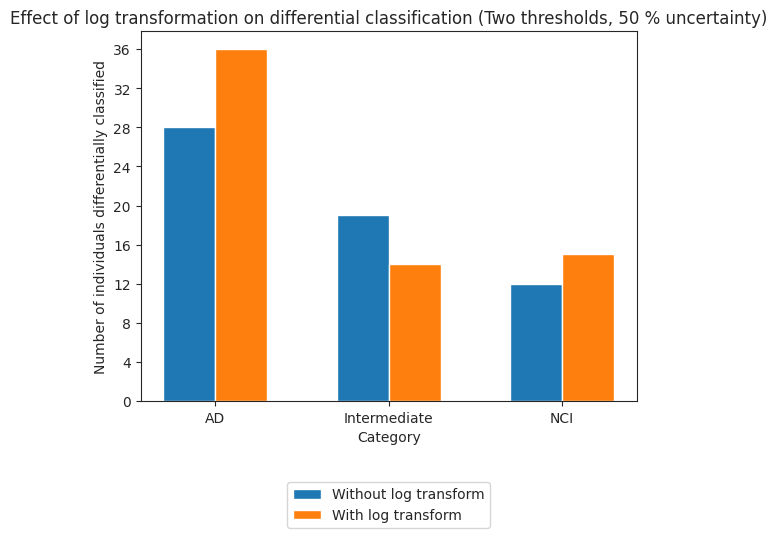

In [39]:
for uncertainty in uncertainties:
    visualize_differential_classification_results_single_threshold(
                ad_diff_cls=single_thres_expt_results.loc[uncertainty, "ad_diff_cls"], 
                nci_diff_cls=single_thres_expt_results.loc[uncertainty, "nci_diff_cls"],
                logTPM_ad_diff_cls=single_thres_expt_results.loc[uncertainty, "logTPM_ad_diff_cls"], 
                logTPM_nci_diff_cls=single_thres_expt_results.loc[uncertainty, "logTPM_nci_diff_cls"],
                uncertainty=uncertainty
        )
    visualize_differential_classification_results_two_thresholds(
                ad_diff_cls=dual_thres_expt_results.loc[uncertainty, "ad_diff_cls"], 
                interm_diff_cls=dual_thres_expt_results.loc[uncertainty, "int_diff_cls"], 
                nci_diff_cls=dual_thres_expt_results.loc[uncertainty, "nci_diff_cls"],
                logTPM_ad_diff_cls=dual_thres_expt_results.loc[uncertainty, "logTPM_ad_diff_cls"], 
                logTPM_interm_diff_cls=dual_thres_expt_results.loc[uncertainty, "logTPM_int_diff_cls"], 
                logTPM_nci_diff_cls=dual_thres_expt_results.loc[uncertainty, "logTPM_nci_diff_cls"],
                uncertainty=uncertainty
        )

In [40]:
dual_thres_expt_results.columns = [
    "Differentially classified (AD, without log)", "Differentially classified (intermediate, without log)", "Differentially classified (NCI, without log)", 
    "Differentially classified (AD, with log)", "Differentially classified (intermediate, with log)", "Differentially classified (NCI, with log)"
]
dual_thres_expt_results.index.name = "Percent uncertainty"

In [41]:
dual_thres_expt_results.to_csv("dual_thres_expt_results.csv")

In [42]:
single_thres_expt_results.columns = [
    "Differentially classified (AD, without log)", "Differentially classified (NCI, without log)", 
    "Differentially classified (AD, with log)", "Differentially classified (NCI, with log)"
]
single_thres_expt_results.index.name = "Percent uncertainty"

In [43]:
single_thres_expt_results.to_csv("single_thre_expt_results.csv")

In [44]:
single_thres_expt_results

,"Differentially classified (AD, without log)","Differentially classified (NCI, without log)","Differentially classified (AD, with log)","Differentially classified (NCI, with log)"
Percent uncertainty,,,,
10,1,0,1,4
25,4,5,4,5
50,12,14,15,13


In [45]:
dual_thres_expt_results

,"Differentially classified (AD, without log)","Differentially classified (intermediate, without log)","Differentially classified (NCI, without log)","Differentially classified (AD, with log)","Differentially classified (intermediate, with log)","Differentially classified (NCI, with log)"
Percent uncertainty,,,,,,
10,3,5,1,8,7,1
25,13,16,4,19,11,4
50,28,19,12,36,14,15


In [46]:
score_stats.columns = ["Mean of linear scores (without log)", "Std.dev. of linear scores (without log)", 
                           "Mean of probabilities (without log)", "Std.dev. of probabilities (without log)",
                           "Mean of linear scores (with log)", "Std.dev. of linear scores (with log)", 
                           "Mean of probabilities (with log)", "Std.dev. of probabilities (with log)"]

In [47]:
score_stats

,Mean of linear scores (without log),Std.dev. of linear scores (without log),Mean of probabilities (without log),Std.dev. of probabilities (without log),Mean of linear scores (with log),Std.dev. of linear scores (with log),Mean of probabilities (with log),Std.dev. of probabilities (with log)
10,-0.00011,11.874852,0.458952,0.475129,0.000419,11.542891,0.467763,0.479053
25,-0.000361,11.886831,0.458421,0.475093,-0.002361,11.559465,0.46728,0.478789
50,0.003702,11.949393,0.456956,0.474725,0.001024,11.609795,0.465637,0.477907


## Comparing Effect of log transform on Standard deviations and Means of Probability scores for each Subject

In [57]:
uncertainty = 50
pred_probs = pred_prob_arrs[uncertainty].reshape((num_patients, num_runs))
log_pred_probs = logTPM_pred_prob_arrs[uncertainty].reshape((num_patients, num_runs))

In [58]:
means, stds = np.mean(pred_probs, axis=1), np.std(pred_probs, axis=1)
logTPM_means, logTPM_stds = np.mean(log_pred_probs, axis=1), np.std(log_pred_probs, axis=1)

[]

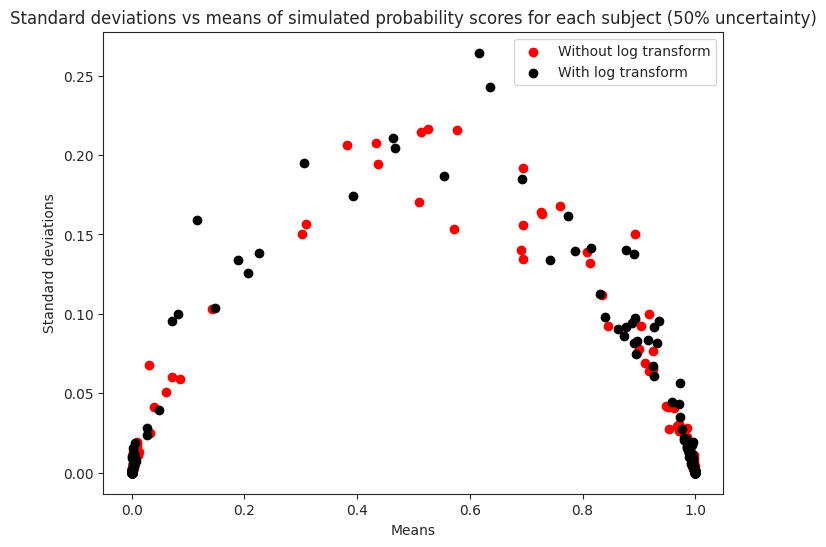

In [59]:
plt.figure(figsize=(8, 6))
plt.scatter(means, stds, color="r", label="Without log transform")
plt.scatter(logTPM_means, logTPM_stds, color="k", label="With log transform")
plt.legend(loc="best")
plt.xlabel("Means")
plt.ylabel("Standard deviations")
plt.title(f"Standard deviations vs means of simulated probability scores for each subject ({uncertainty}% uncertainty)")
plt.plot()

[]

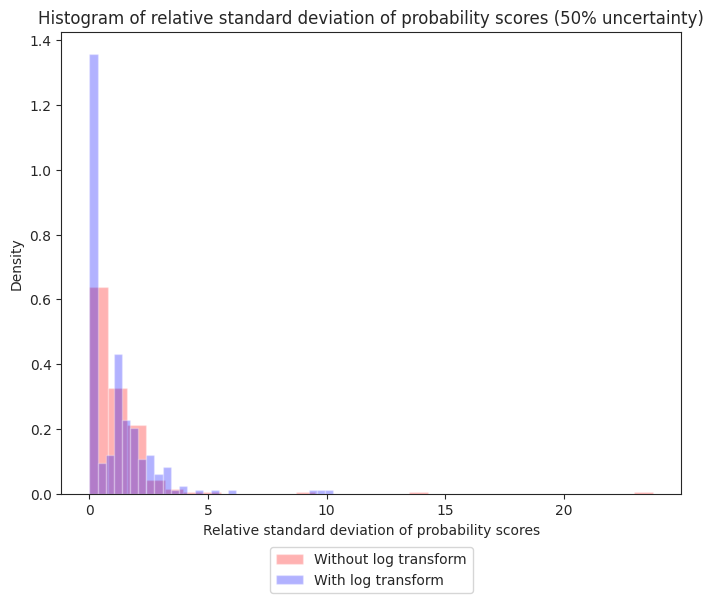

In [60]:
plt.figure(figsize=(8, 6))
plt.hist(stds / means, 30, density=True, color='red', alpha=0.3, label="Without log transform")
plt.hist(logTPM_stds / logTPM_means, 30, density=True, color='blue', alpha=0.3, label="With log transform")
plt.xlabel("Relative standard deviation of probability scores")
plt.ylabel("Density")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))
plt.title(f"Histogram of relative standard deviation of probability scores ({uncertainty}% uncertainty)")
plt.plot()

## Comparing effect of Log transform on Distribution of Linear and Probability Scores

In [61]:
uncertainty = 50
lin_scores, pred_probs = lin_score_arrs[uncertainty], pred_prob_arrs[uncertainty]
log_lin_scores, log_pred_probs = logTPM_lin_score_arrs[uncertainty], logTPM_pred_prob_arrs[uncertainty]

In [62]:
print(f"{np.median(lin_scores)=}, {np.median(pred_probs)=}")
print(f"{np.mean(lin_scores)=}, {np.mean(pred_probs)=}")
print(f"{np.std(lin_scores)=}, {np.std(pred_probs)=}")
print()
print(f"{np.median(log_lin_scores)=}, {np.median(log_pred_probs)=}")
print(f"{np.mean(log_lin_scores)=}, {np.mean(log_pred_probs)=}")
print(f"{np.std(log_lin_scores)=}, {np.std(log_pred_probs)=}")

np.median(lin_scores)=np.float32(-2.3174033), np.median(pred_probs)=np.float32(0.08969186)
np.mean(lin_scores)=np.float32(0.0037024498), np.mean(pred_probs)=np.float32(0.45695552)
np.std(lin_scores)=np.float32(11.949393), np.std(pred_probs)=np.float32(0.47472504)

np.median(log_lin_scores)=np.float32(-1.8378735), np.median(log_pred_probs)=np.float32(0.137303)
np.mean(log_lin_scores)=np.float32(0.0010236786), np.mean(log_pred_probs)=np.float32(0.46563658)
np.std(log_lin_scores)=np.float32(11.609795), np.std(log_pred_probs)=np.float32(0.4779073)


In [63]:
st.ttest_rel(np.ravel(lin_scores), np.ravel(log_lin_scores))

TtestResult(statistic=np.float64(0.4331696090026424), pvalue=np.float64(0.664891940236797), df=np.int64(242999))

[]

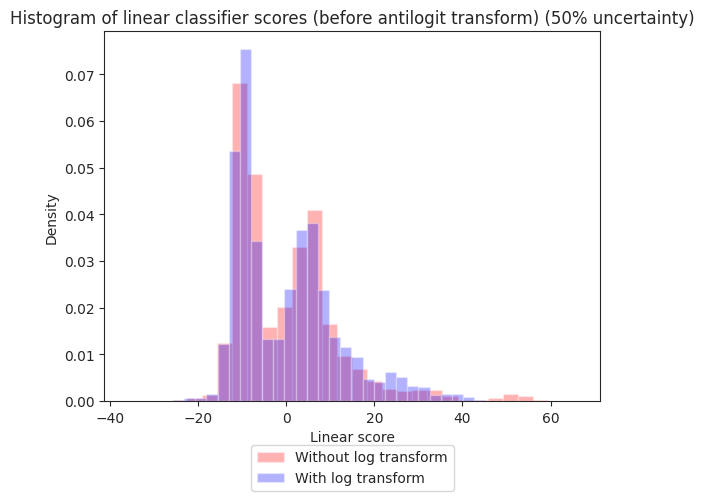

In [64]:
plt.hist(np.ravel(lin_scores), 30, density=True, color='red', alpha=0.3, label="Without log transform")
plt.hist(np.ravel(log_lin_scores), 30, density=True, color='blue', alpha=0.3, label="With log transform")
plt.xlabel("Linear score")
plt.ylabel("Density")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))
plt.title(f"Histogram of linear classifier scores (before antilogit transform) ({uncertainty}% uncertainty)")
plt.plot()

[]

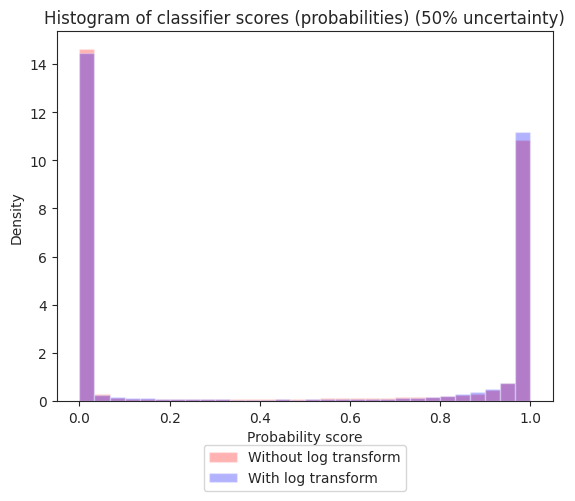

In [65]:
plt.hist(np.ravel(pred_probs), 30, density=True, color='red', alpha=0.3, label="Without log transform")
plt.hist(np.ravel(log_pred_probs), 30, density=True, color='blue', alpha=0.3, label="With log transform")
plt.xlabel("Probability score")
plt.ylabel("Density")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))
plt.title(f"Histogram of classifier scores (probabilities) ({uncertainty}% uncertainty)")
plt.plot()